In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [149]:
data1 = pd.read_csv("data/astrometry_NACO.csv")
data2 = pd.read_csv("data/astrometry_SHARP.csv")


/tmp/ipykernel_3990289/2281247065.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)
/tmp/ipykernel_3990289/2281247065.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return phi, torch.tensor(u, dtype=torch.float32)#/self.norm_const


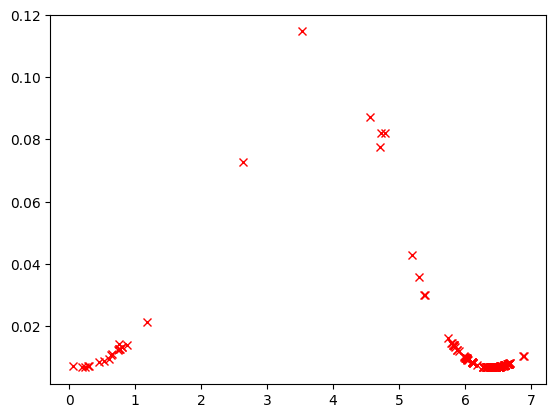

In [150]:
class getdata():
    def __init__(self, scaling=1e-1, cat_data=False, augment_data=False, std_data=False):
        self.augment_data = augment_data
        self.std_data = std_data
        micro_arcsec_to_au = torch.pi / (3600*180) * 8.3 * 1000 * 206265 * scaling # to units 1e-2 AU

        data1 = pd.read_csv("data/astrometry_NACO.csv")
        data2 = pd.read_csv("data/astrometry_SHARP.csv")

        # t,x,x_err,y,y_err
                
        y1 = data1.iloc[:,1].values * micro_arcsec_to_au 
        y_std1 = data1.iloc[:,2].values * micro_arcsec_to_au
        x1 = data1.iloc[:,3].values * micro_arcsec_to_au
        x_std1 = data1.iloc[:,4].values * micro_arcsec_to_au

        y2 = data2.iloc[:,1].values * micro_arcsec_to_au
        y_std2 = data2.iloc[:,2].values * micro_arcsec_to_au
        x2 = data2.iloc[:,3].values * micro_arcsec_to_au
        x_std2 = data2.iloc[:,4].values * micro_arcsec_to_au

        if cat_data:
            self.x = torch.cat((torch.tensor(x1), torch.tensor(x2))).unsqueeze(1)
            self.y = torch.cat((torch.tensor(y1), torch.tensor(y2))).unsqueeze(1)
            self.x_std = torch.cat((torch.tensor(x_std1), torch.tensor(x_std2))).unsqueeze(1)
            self.y_std = torch.cat((torch.tensor(y_std1), torch.tensor(y_std2))).unsqueeze(1)
        else:
            self.x = torch.tensor(x1).unsqueeze(1)
            self.y = torch.tensor(y1).unsqueeze(1)
            self.x_std = torch.tensor(x_std1).unsqueeze(1)
            self.y_std = torch.tensor(y_std1).unsqueeze(1)

        self.u = 1/np.sqrt(self.x**2 + self.y**2)
        phi = np.arccos(self.x*self.u) 
        self.phi = torch.where(self.y<0., -phi, phi).float()
        self.phi[:len(y1)] += torch.pi * 2
        self.phi = torch.where(self.phi<0, self.phi+2*torch.pi, self.phi)
        self.phi = torch.where(self.phi>2.2*torch.pi, self.phi-2*torch.pi, self.phi)

        self.u = torch.tensor(self.u, dtype=torch.float32)
        #self.norm_const = torch.mean(self.u)

    def __call__(self):
        if self.augment_data:
            phi = (self.phi + (torch.randint(low=0,high=3,size=self.phi.shape) - 1) * 2 * torch.pi)
        else:
            phi = self.phi

        if self.std_data:
            x_ = self.x + torch.normal(0, self.x_std)
            y_ = self.y + torch.normal(0, self.y_std)
            u = 1/torch.sqrt(x_**2 + y_**2)
        else:
            u = self.u

        return phi, torch.tensor(u, dtype=torch.float32)#/self.norm_const
    
d = getdata(augment_data=False, std_data=False, cat_data=True)
x, y = d()
plt.plot(x,y,'rx')
#x, y = d()
#plt.plot(x,y,'kx')

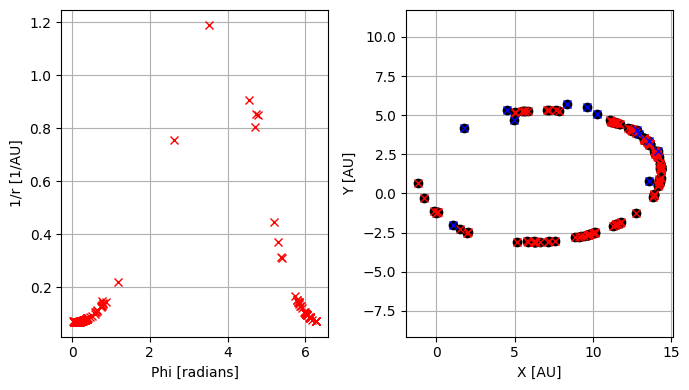

In [151]:
micro_arcsec_to_au = torch.pi / (3600*180) * 8 * 1000 * 206265 * 1e-2 # to units 1e-2 AU

y1 = data1.iloc[:,1].values * micro_arcsec_to_au 
x1 = data1.iloc[:,3].values * micro_arcsec_to_au

y2 = data2.iloc[:,1].values * micro_arcsec_to_au
x2 = data2.iloc[:,3].values * micro_arcsec_to_au


# X values
phi1 = np.arctan(y1/x1)
phi2 = np.arctan(y2/x2)
phi = torch.cat((torch.tensor(phi1, dtype=torch.float32), torch.tensor(phi2, dtype=torch.float32))).unsqueeze(1)

#phi_aug = phi + (torch.randint(low=0,high=3,size=phi.shape) - 1) * torch.pi


# Y values
u1 = 1/np.sqrt(x1**2 + y1**2)
u2 = 1/np.sqrt(x2**2 + y2**2)

u = torch.cat((torch.tensor(u1, dtype=torch.float32), torch.tensor(u2, dtype=torch.float32))).unsqueeze(1)

cat_data = True
if cat_data:    
    x_ = torch.cat((torch.tensor(x1), torch.tensor(x2))).unsqueeze(1)
    y_ = torch.cat((torch.tensor(y1), torch.tensor(y2))).unsqueeze(1)
else:
    x_ = torch.tensor(x1).unsqueeze(1)
    y_ = torch.tensor(y1).unsqueeze(1)

phi = np.arccos(x_*u)
phi = torch.where(y_<0., -phi, phi).float()
phi = torch.where(phi<0, phi+2*torch.pi, phi)



fig, ax = plt.subplots(figsize=(7,4), ncols=2)
#ax.set_xscale("log")

ax[0].plot(phi, u, 'rx')
ax[0].set_ylabel("1/r [1/AU]")
ax[0].set_xlabel("Phi [radians]")



ax[1].plot(np.cos(phi[:,0])/u[:,0], np.sin(phi[:,0])/u[:,0], 'ko')
ax[1].plot(x1, y1, 'rx')
ax[1].plot(x2, y2, 'bx')
ax[1].set_ylabel("Y [AU]")
ax[1].set_xlabel("X [AU]")

ax[1].axis('equal')

[axi.grid() for axi in ax]

plt.tight_layout()

#ax[1].set_ylim(-50,50); ax[1].set_xlim(-140, -60)

In [159]:
# Initialize model
lr = 1e-3

model = PINN(1, 1, chans=[4,8,4]).to(device)
#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters())#, weight_decay=1e-3)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses = [[], [], []]
params = [[], [], []]

phi_lin = torch.linspace(-3*torch.pi, 6*torch.pi, steps=1000).view(-1,1).requires_grad_(True)


#phys_loss_weight = .5

u = u.to(device)
phi = phi.to(device)

phi_aug = (phi + (torch.randint(low=0,high=5,size=phi.shape, device=device) - 2) * 2 * torch.pi)
phi_lin = phi_lin.to(device)


stardata = getdata(augment_data=True, std_data=True, cat_data=True)

phi_aug, u = stardata()
phi_aug = phi_aug.to(device)
u = u.to(device)

/tmp/ipykernel_3990289/2281247065.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)
/tmp/ipykernel_3990289/2281247065.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return phi, torch.tensor(u, dtype=torch.float32)#/self.norm_const


In [175]:
epochs = 20_000
phys_loss_weight = 1e-1


for epoch in tqdm(range(epochs)):
    phi_aug, u = stardata()
    phi_aug = phi_aug.to(device)
    u = u.to(device)
    
    out = model(phi_aug)

    #MSEloss = criterion(out, u)
    #MSEloss = criterion(torch.log(out + 1e-8), torch.log(u + 1e-8))
    MSEloss = torch.mean(torch.abs(out - u) / (torch.abs(u) + 1e-8))
    #MSEloss += criterion(out, u)

    #phi_lin = (torch.randn(1000, 1, requires_grad=True) * 10).to(device)
    PHYSloss = phys_loss_weight * model.physical_loss(phi_lin)
    #PHYSloss = phys_loss_weight * model.physical_loss(phi_aug)
    #phys_loss_weight *= 1.005
    #phys_loss_weight = min(phys_loss_weight, max_phys_loss_weight)

    loss = MSEloss + PHYSloss

    optimizer.zero_grad()
    loss.backward()
    #MSEloss.backward()
    #PHYSloss.backward()
    optimizer.step()

    losses[0].append(loss.cpu().detach().numpy())
    losses[1].append(MSEloss.cpu().detach().numpy())
    losses[2].append(PHYSloss.cpu().detach().numpy())

    params[0].append(model.get_e().item())
    #params[1].append(model.get_mu().item())
    params[1].append(model.get_p().item())
    params[2].append(model.get_M().item())


  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_3990289/2281247065.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return phi, torch.tensor(u, dtype=torch.float32)#/self.norm_const
100%|██████████| 20000/20000 [02:20<00:00, 142.85it/s]


e = 0.8504345417022705
p = 22.560543060302734
M = 0.37437987327575684


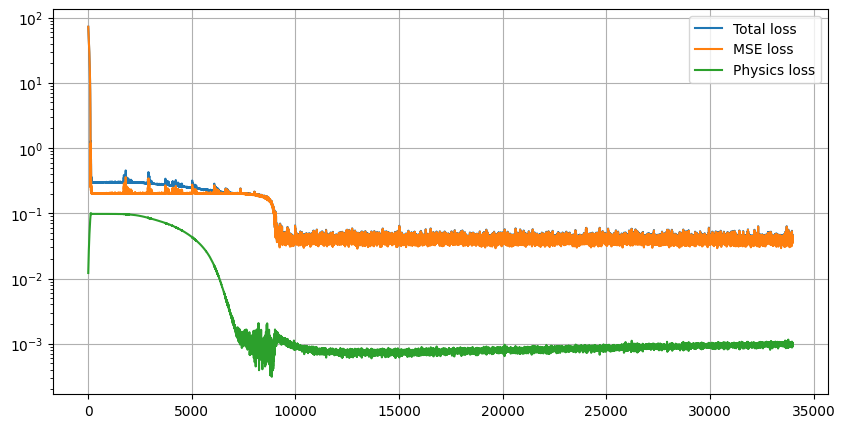

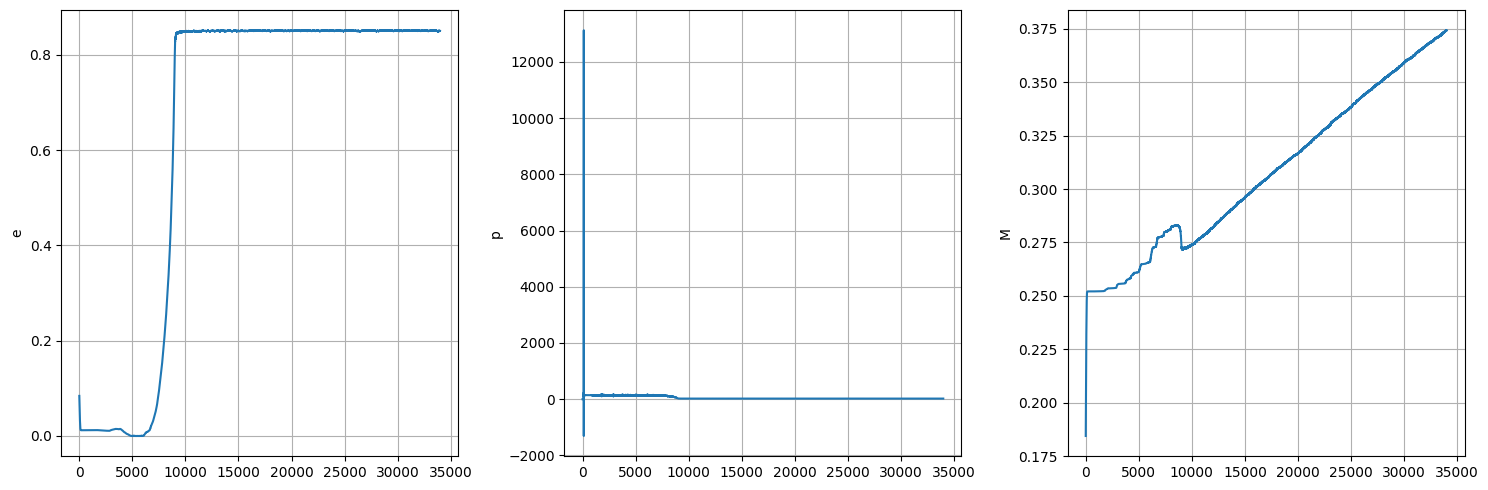

In [176]:
print("e =", model.get_e().item())
#print("p =", model.get_M().item()/model.get_mu().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())
#print("mu =", model.get_mu().item())

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(losses[0], label="Total loss")
ax.plot(losses[1], label="MSE loss")
ax.plot(losses[2], label="Physics loss")

ax.grid()
ax.legend()
ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
#ax[1].set_ylabel(r"$\mu$")
ax[1].set_ylabel("p")
ax[1].grid()

ax[2].plot(params[2])
ax[2].set_ylabel("M")
ax[2].grid()

plt.tight_layout()
plt.show()

# e, p, M


#        self.e = torch.nn.Parameter(torch.tensor(0.8))
#        self.p = torch.nn.Parameter(torch.tensor(220.))
#        self.M = torch.nn.Parameter(torch.tensor(.04))
# mu ~ 1.8e-4


/tmp/ipykernel_3990289/2281247065.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return phi, torch.tensor(u, dtype=torch.float32)#/self.norm_const


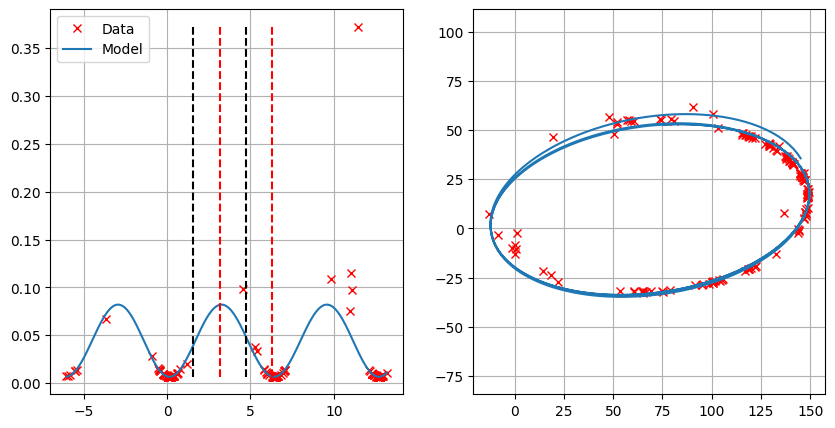

In [177]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
_phi, _u = stardata()
ax[0].plot(_phi, _u, 'rx', label="Data")


theta = torch.linspace(_phi.min(), _phi.max(), steps=1000, dtype=torch.float32).to(device)
u_ = model(theta.unsqueeze(1)).cpu().detach().numpy()[:,0]
theta = theta.cpu()
ax[0].plot(theta, u_, label="Model")
ax[0].vlines(torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
ax[0].vlines(3*torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
ax[0].vlines(2*torch.pi, _u.min(), _u.max(), 'r', ls='--')
ax[0].vlines(torch.pi, _u.min(), _u.max(), 'r', ls='--')


#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(_phi[:,0])/_u[:,0], torch.sin(_phi[:,0])/_u[:,0], "rx")

r = 1/u_

theta = theta.numpy()
ax[1].plot(r*np.cos(theta), r*np.sin(theta));


[axi.grid() for axi in ax]
ax[1].axis('equal')
#ax[0].axis('equal')
ax[0].legend()
#ax.set_xscale("log")
#ax[0].set_xlim(0,3)
#ax[0].set_ylim(0,2)

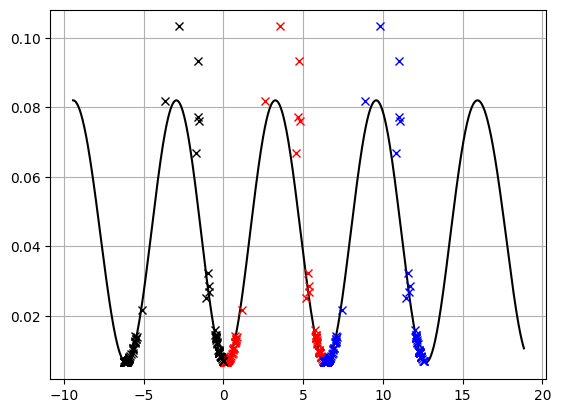

In [178]:
fig, ax = plt.subplots()
ax.grid()

u_ = model(phi_lin).cpu().detach().numpy()[:,0]
theta = phi_lin.cpu().detach().numpy()

ax.plot(theta[:,0], u_, 'k')


ax.plot(phi.cpu(), u.cpu(), "rx")
phi_aug_ = phi + 2 * torch.pi
ax.plot(phi_aug_.cpu(), u.cpu(), 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug.cpu(), u.cpu(), 'kx')

#plt.xlim(-2, -1)
#r = 1/u_
#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


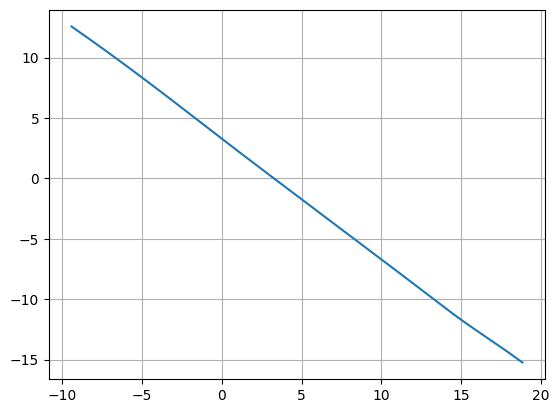

In [179]:
x = phi_lin
y = model.nn(x)

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

plt.plot(x,y)
plt.grid()

In [ ]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

torch.save(state, f'S-STAR-PINN.pth')